# Loss function prototyping

## Data loading

In [3]:
#TODO: load image and 3D model

## Reprojection

In [4]:
#TODO: Reproject 3D model to image plane

## Loss

In [2]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from src.ops import keypoint_l1_loss
from __future__ import print_function
from src.tf_smpl.projection import batch_orth_proj_idrot
from sklearn.neighbors import NearestNeighbors
sess = tf.InteractiveSession()

In [3]:
sess.run

<bound method InteractiveSession.run of <tensorflow.python.client.session.InteractiveSession object at 0xb380e5f90>>

In [73]:
kp_gt = tf.random.uniform(
    [1, 1, 3],
    minval=0,
    maxval=3,
    dtype=tf.dtypes.float32,
    seed=None,
    name='kp_gt'
)

kp_pred = tf.random.uniform(
    [1, 1, 2],
    minval=0,
    maxval=3,
    dtype=tf.dtypes.float32,
    seed=None,
    name='kp_pred'
)

A = tf.constant([[[1, 2], [4, 5]]])
print(A)

B = tf.constant([[[1, 3], [1, 5]]])
print(B)

Tensor("Const_8:0", shape=(1, 2, 2), dtype=int32)
Tensor("Const_9:0", shape=(1, 2, 2), dtype=int32)


In [80]:
print(A.eval())
print(B.eval())
print(A)

[[[1 2]
  [4 5]]]
[[[1 3]
  [1 5]]]
Tensor("Const_8:0", shape=(1, 2, 2), dtype=int32)


In [15]:
nb = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(B)
ds, inds = nb.kneighbors(A)

ValueError: Expected 2D array, got scalar array instead:
array=Tensor("Const_5:0", shape=(2, 2), dtype=int32).
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [7]:
kp_gt.eval()

array([[[0.26172101, 2.74757   , 1.0474491 ]]], dtype=float32)

In [8]:
kp_pred.eval()

array([[[0.6464578, 0.6295742]]], dtype=float32)

In [9]:
#TODO: get cams, shapes, poses, silhoette_points
cams, shapes, poses, silhoette_points

verts, Js, pred_Rs = self.smpl(shapes, poses, get_skin=True)

pred_kp = batch_orth_proj_idrot(
            Js, cams, name='proj2d_stage%d' % i)

pred_sp = batch_orth_proj_idrot(
            silhouette_points, cams, name='proj2d_stage%d' % i)

NameError: name 'cams' is not defined

In [92]:
def bidirectional_dist(A, B):
    nbrs_B = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(A)
    distances_BA, _ = nbrs_B.kneighbors(B)
    nbrs_A = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(B)
    distances_AB, _ = nbrs_A.kneighbors(A)
    return distances_BA.sum() + distances_AB.sum()

In [95]:
def mesh_reprojection_loss(silhouette_gt, silhouette_pred, scale=1., name=None):
    """
    ADL4CV
    Computes bidirectional distance between ground truth silhouette and predicted silhouette
    Inputs:
        silhouette_gt:      N x K x 2
        silhouette_pred:    N x K x 2
    """
    with tf.name_scope(name, "mesh_reprojection_loss", [silhouette_gt, silhouette_pred]):
        N = silhouette_gt.shape[0]
        K = silhouette_gt.shape[1]
        silhouette_gt = tf.reshape(silhouette_gt, (-1, 2))
        silhouette_pred = tf.reshape(silhouette_pred, (-1, 2))
        # try simple L1 distance for now
        sil_gt_np = silhouette_gt.eval()
        sil_pred_np = silhouette_pred.eval()
        loss = 0
        for i in range(N):
            loss += bidirectional_dist(sil_gt_np[i*K:(i+1)*K,:], sil_pred_np[i*K:(i+1)*K,:])
        return loss

In [96]:
res = mesh_reprojection_loss(A, B)

In [97]:
res.eval()

AttributeError: 'numpy.float64' object has no attribute 'eval'

In [45]:
diff = tf.losses.absolute_difference(A[:,:,:2], B)
diff.eval()

1.0

Nearest Neighbor

In [18]:
mean = [0, 0]
cov = [[1, 3], [3, 5]]
X = np.random.multivariate_normal(mean, cov, 500)

/anaconda3/envs/ADL4CV/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
alpha = 10 #in degree
delta_x = 0.3
delta_y = 1.5
R = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])
T = np.array([[delta_x, delta_y]])
Y = np.dot(X, R) + T

In [36]:
nbrs_Y = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X)
distances_YX, indices_YX = nbrs_Y.kneighbors(Y)

In [37]:
nbrs_X = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Y)
distances_XY, indices_XY = nbrs_X.kneighbors(X)

In [67]:
loss = distances_XY.sum() + distances_YX.sum()

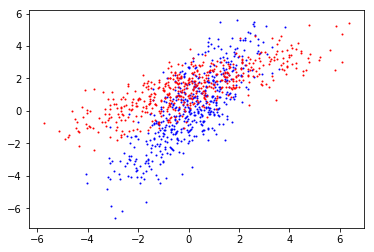

In [65]:
plt.plot(X[:,0], X[:,1], 'b.', markersize=2)
plt.plot(Y[:,0], Y[:,1], 'r.', markersize=2)

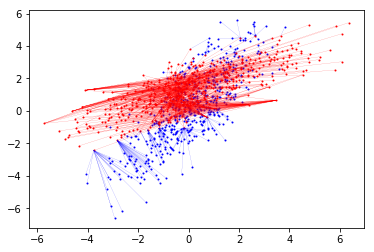

In [69]:
plt.plot(X[:,0], X[:,1], 'b.', markersize=2)
plt.plot(Y[:,0], Y[:,1], 'r.', markersize=2)

for x in range(X.shape[0]):
    plt.plot([X[x,0], Y[indices_XY[x, 0],0]], [X[x,1], Y[indices_XY[x, 0],1]], color='b', linewidth=0.1)

for y in range(Y.shape[0]):
    plt.plot([Y[y,0], Y[indices_YX[y, 0],0]], [Y[y,1], Y[indices_YX[y, 0],1]], color='r', linewidth=0.11)

#plt.plot([0, -5], [-5, 5], color='g', linewidth=1)